In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import geopandas
from datetime import date
from matplotlib.colors import ListedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable

%run ../global_variables.py ./
%run ../global_functions.py ./

%matplotlib notebook

In [3]:
def compute_annual_hydro_sum(hydro_month,hydro_var_name,data,basin_name,time_overlap):
    hydro_basin=hydro_month.loc[basin_name,['{}_{} {}'.format(hydro_var_name,data,d.date()) for d in time_overlap[:-1]]].to_frame()
    hydro_basin.index=time_overlap[:-1]
    hydro_basin['year']=np.repeat(np.arange(min_year,max_year),12)
    
    if np.sum(np.isnan(hydro_basin[basin_name]))==0:
        hydro_year=hydro_basin.groupby('year').sum()
    else:
        hydro_year=np.nan*np.ones_like(max_year-min_year)
    # transform to Series
    hydro_year=pd.Series(hydro_year.values.flatten(),index=hydro_year.index,name=basin_name)
    return hydro_year

def compute_mean_annual_hydro_sum(hydro_month,hydro_var_name,data,basin_name,time_overlap):
    #hydro_year=compute_annual_hydro_sum(hydro_month,hydro_var_name,data,basin_name,time_overlap)
    hydro_basin=hydro_month.loc[basin_name,['{}_{} {}'.format(hydro_var_name,data,d.date()) for d in time_overlap[:-1]]].to_frame()
    hydro_basin.index=time_overlap[:-1]
    hydro_basin['year']=np.repeat(np.arange(min_year,max_year),12)
    
    if np.sum(np.isnan(hydro_basin[basin_name]))==0:
        hydro_year=hydro_basin.groupby('year').sum()
        # transform to Series
        hydro_year=pd.Series(hydro_year.values.flatten(),index=hydro_year.index,name=basin_name)
        return hydro_year.mean(),hydro_year.std()
    else:
        return np.nan,np.nan

def compute_annual_hydro_diff(hydro_month,hydro_var_name,data,basin_name,time_overlap):
    hydro_basin=hydro_month.loc[basin_name,['{}_{} {}'.format(hydro_var_name,data,d.date()) for d in time_overlap]]
    hydro_basin.index=time_overlap
    hydro_year=pd.Series(hydro_basin.values[12::12]-hydro_basin.values[:-12:12],index=np.arange(min_year,max_year))
    return hydro_year

def compute_mean_annual_hydro_diff(hydro_month,hydro_var_name,data,basin_name,time_overlap):
    hydro_year=compute_annual_hydro_diff(hydro_month,hydro_var_name,data,basin_name,time_overlap)
    return hydro_year.mean(),hydro_year.std()

In [4]:
#basins=load_basins_data()
basins=geopandas.read_file("../datasets/basins/basins_with_climate_zones.shp")
basins.set_index("NAME",inplace=True)

world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
world.drop([159,22,23],inplace=True) # Antarctica, Greenland,Seven seas (tiny islands Indian ocean)

In [5]:
data='GPCC'
hydro_var_name='P'

hydro_month=pd.read_csv('../results/hydrology/{}_{}_monthly.csv'.format(hydro_var_name,data),index_col=[0])
time_hydro=pd.to_datetime(hydro_month.columns.str[len(hydro_var_name)+1+len(data):])

In [6]:
month_start=1
min_year=np.unique(time_hydro.year).min()+1
max_year=np.unique(time_hydro.year).max()
time_cycle=pd.date_range(start=date(min_year,month_start,1),end=date(max_year,month_start+1,1),freq='SM')[::2]

In [7]:
for basin_name in basins.index:
    basins.loc[basin_name,'{} mean annual'.format(hydro_var_name)]=compute_mean_annual_hydro_sum(hydro_month,hydro_var_name,data,basin_name,time_cycle)[0]

<IPython.core.display.Javascript object>


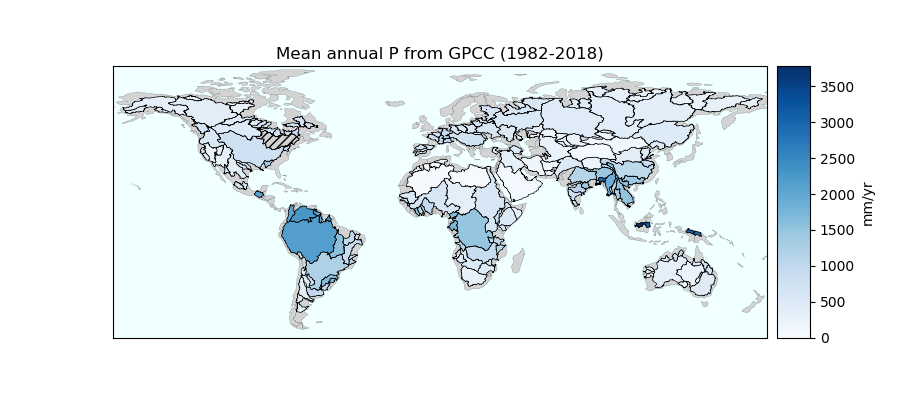

In [8]:
fig, ax = plt.subplots(figsize=(9,4))
ax.set_aspect('equal')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)

world.plot(ax=ax,color='lightgrey',edgecolor='black',linewidth=0.1)
norm,cmap=define_cmap(hydro_var_name,basins['{} mean annual'.format(hydro_var_name)].values,percentile=False)
basins.plot(ax=ax,column='{} mean annual'.format(hydro_var_name),edgecolor='black',linewidth=0.4,
                          legend=True,cax=cax,
                          missing_kwds={"color": "lightgrey",'hatch':'////'},
                          legend_kwds={'label': "mm/yr",
                              #'extend':'both'
                          },
                    norm=norm,cmap=cmap
                    )
ax.set_facecolor("azure")
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlim([-170,180])
ax.set_ylim([-60,85])
ax.set_title('Mean annual {} from {} ({}-{})'.format(hydro_var_name,data,min_year,max_year-1)) 
plt.show()

In [9]:
print('Number of basins with missing values {} = {}'.format(data,np.sum(np.sum(np.isnan(hydro_month),axis=1)>0)))

Number of basins with missing values GPCC = 1


# Store annual components

For each dataset, store the mean annual value over a basin.

In [10]:
list_data_P=['CPC','CRU','ERA5_Land','GLDAS20','GPCC','GPCP','GPM','JRA55','MERRA2','MSWEP','TRMM']
list_data_ET=['ERA5_Land','FLUXCOM','GLEAM','GLDAS20_NOAH36','GLDAS20_CLSM25','GLDAS20_VIC412',
              'GLDAS21_NOAH36','GLDAS21_CLSM25','GLDAS21_VIC412',
              'GLDAS22_CLSM25','JRA55',
              'MERRA2','MOD16','SSEBop']
list_data_R=['ERA5_Land','GLDAS20_NOAH36','GLDAS20_CLSM25','GLDAS20_VIC412',
             'GLDAS21_NOAH36','GLDAS21_CLSM25','GLDAS21_VIC412',
             'GLDAS22_CLSM25','JRA55',
             'GRUN','MERRA2']

list_data={'P':list_data_P,
          'ET':list_data_ET,
          'R':list_data_R}

month_start=1
time_idx=pd.date_range(date(2003,3,1),date(2014,12,1),freq='SM')[::2]
min_year=np.unique(time_idx.year).min()+1
max_year=np.unique(time_idx.year).max()
time_cycle=pd.date_range(start=date(min_year,month_start,1),end=date(max_year,month_start+1,1),freq='SM')[::2]

In [13]:
hydro_var_name='R'

df=pd.DataFrame(np.zeros((basins.shape[0],len(list_data[hydro_var_name]))),
                index=basins.index,
               columns=list_data[hydro_var_name])

for data in list_data[hydro_var_name]:
    print(data)
    hydro_month=pd.read_csv('../results/hydrology/{}_{}_monthly.csv'.format(hydro_var_name,data),index_col=[0])
    for basin_name in basins.index:
        df.loc[basin_name,'{}'.format(data)]=compute_mean_annual_hydro_sum(hydro_month,hydro_var_name,data,basin_name,time_cycle)[0]
df.to_csv('../results/annual_comp/{}.csv'.format(hydro_var_name))

ERA5_Land
GLDAS20_NOAH36
GLDAS20_CLSM25
GLDAS20_VIC412
GLDAS21_NOAH36
GLDAS21_CLSM25
GLDAS21_VIC412
GLDAS22_CLSM25
JRA55
GRUN
MERRA2


<IPython.core.display.Javascript object>


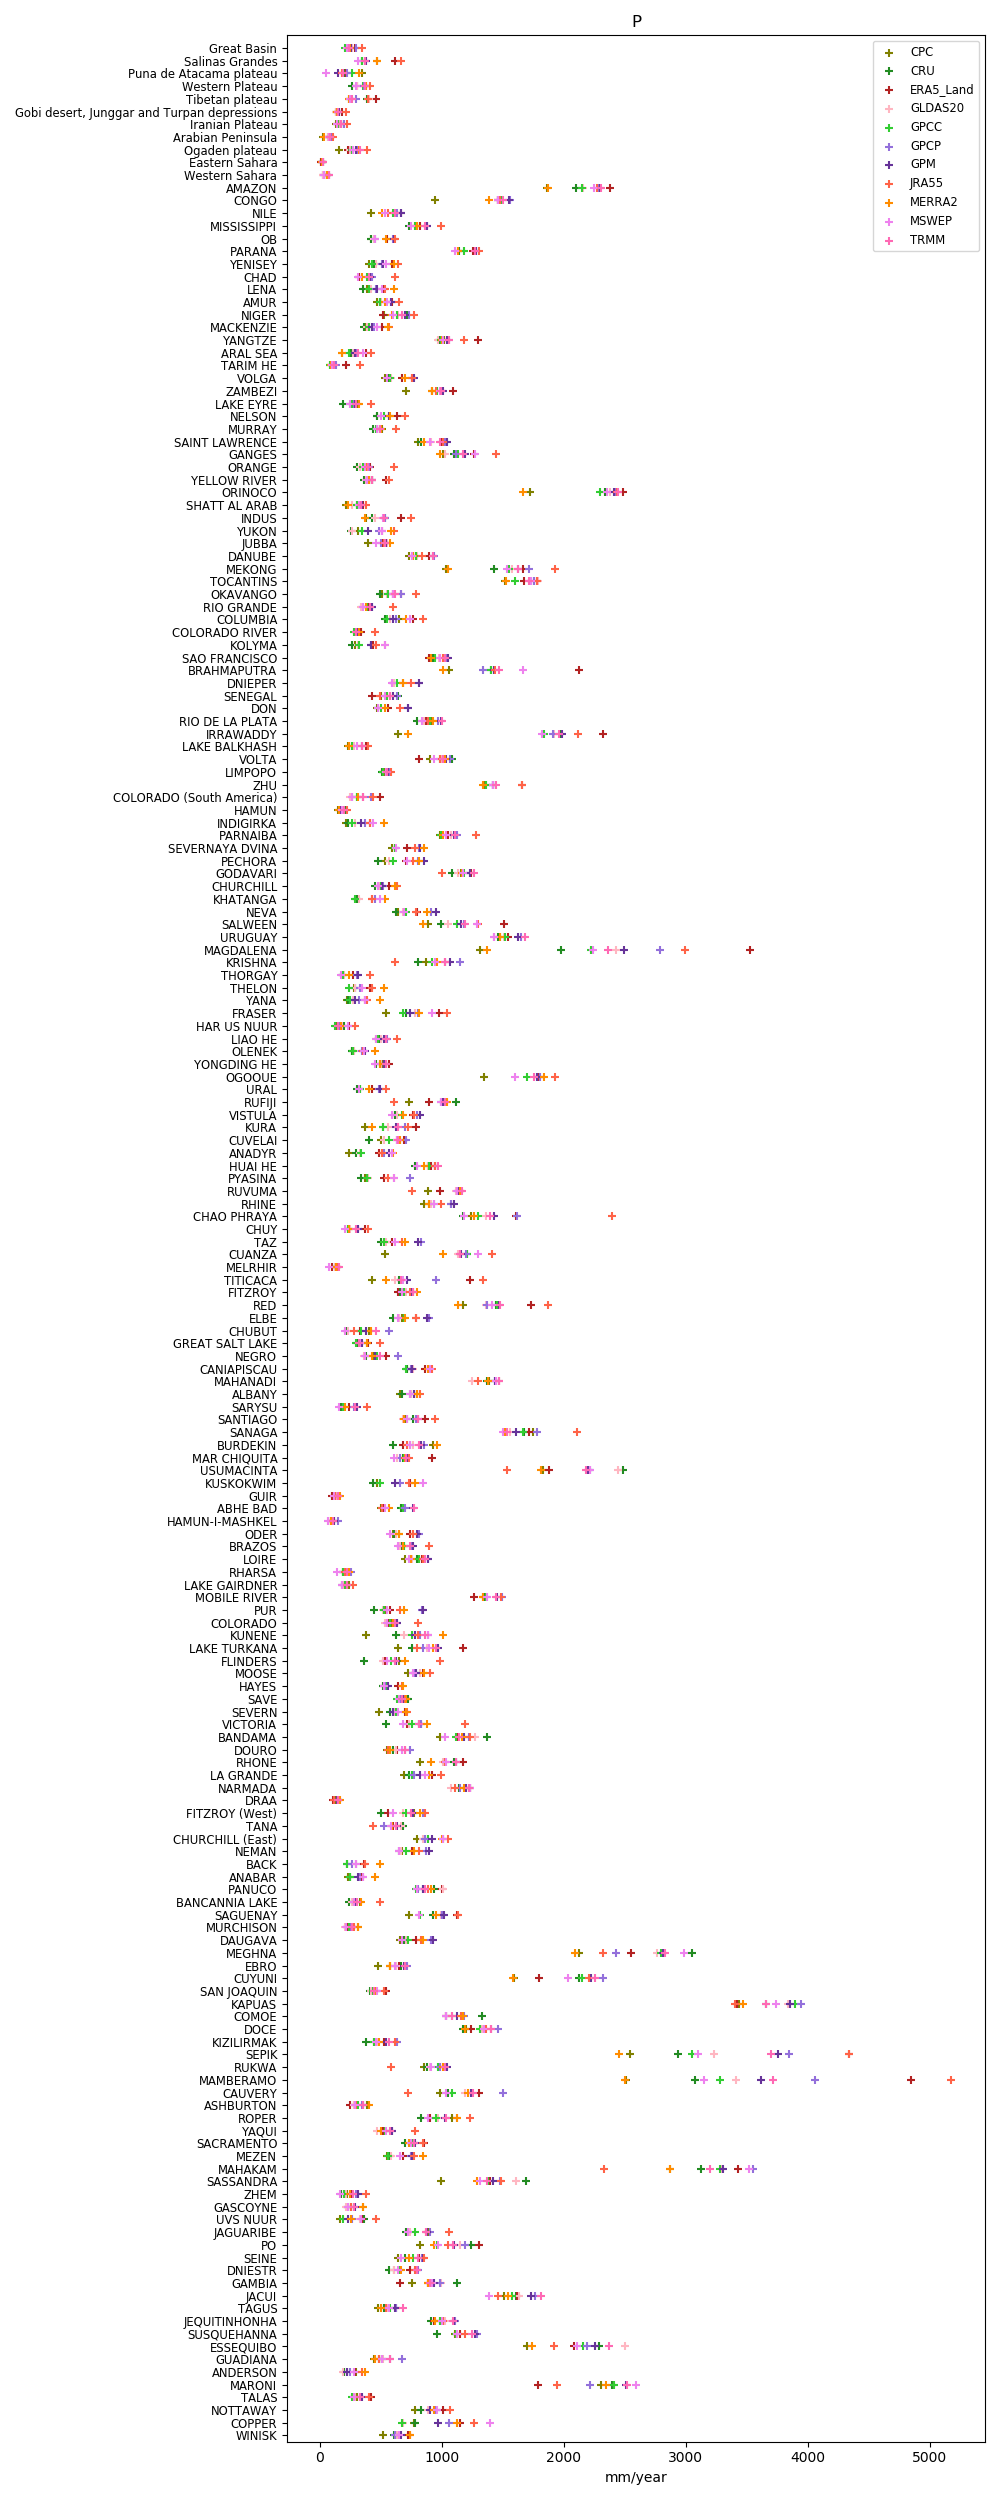

In [15]:
hydro_var_name='P'
df=pd.read_csv('../results/annual_comp/{}.csv'.format(hydro_var_name),index_col=[0])
#df=df.loc[basins.sort_values(by='MAIN_CLIMATE').index]

plt.figure(figsize=(10,25))
for i,data in enumerate(list_data[hydro_var_name]):
    plt.scatter(df[data].values,np.arange(df.shape[0]),marker='+',c=colors_dataset[data],
               label=data)
plt.legend(ncol=1,fontsize='small')
plt.ylim([-0.5,df.shape[0]])
plt.yticks(np.arange(df.shape[0]),df.index,fontsize='small')
plt.xlabel('mm/year')
plt.title(hydro_var_name)
plt.tight_layout()
plt.show()

# Tables of components per basin

For a selection of basins, mean value of the annual component over all datasets, and standard deviation over datasets. Show the uncertainty in the annual value.

In [16]:
P_mean=pd.read_csv('../results/annual_comp/P.csv',index_col=[0])
ET_mean=pd.read_csv('../results/annual_comp/ET.csv',index_col=[0])
R_mean=pd.read_csv('../results/annual_comp/R.csv',index_col=[0])

In [17]:
#list_basins=['SEPIK','MAMBERAMO','MAHAKAM','KAPUAS']
list_basins=['MAGDALENA','CUYUNI','ESSEQUIBO','MARONI','AMAZON','ORINOCO']
df=pd.DataFrame(np.zeros((len(list_basins),3)),index=list_basins,columns=['P (mm/year)','ET (mm/year)','R (mm/year)'])

for basin_name in list_basins:
    df.loc[basin_name,'P (mm/year)']='{:.0f} $\pm$ {:.0f}'.format(P_mean.loc[basin_name].mean(),
                                                                  P_mean.loc[basin_name].std())
    df.loc[basin_name,'ET (mm/year)']='{:.0f} $\pm$ {:.0f}'.format(ET_mean.loc[basin_name].mean(),
                                                                  ET_mean.loc[basin_name].std())
    df.loc[basin_name,'R (mm/year)']='{:.0f} $\pm$ {:.0f}'.format(R_mean.loc[basin_name].mean(),
                                                                  R_mean.loc[basin_name].std())
    
df

,P (mm/year),ET (mm/year),R (mm/year)
MAGDALENA,2339 $\pm$ 650,1157 $\pm$ 216,1373 $\pm$ 498
CUYUNI,2051 $\pm$ 269,1395 $\pm$ 223,766 $\pm$ 327
ESSEQUIBO,2121 $\pm$ 251,1314 $\pm$ 217,946 $\pm$ 405
MARONI,2312 $\pm$ 247,1406 $\pm$ 269,885 $\pm$ 364
AMAZON,2177 $\pm$ 172,1251 $\pm$ 196,958 $\pm$ 251
ORINOCO,2269 $\pm$ 289,1237 $\pm$ 200,1090 $\pm$ 315


In [18]:
print(df.to_latex(float_format="%.0f",escape=False).replace('rule','hline'))

\begin{tabular}{llll}
\tophline
{} &     P (mm/year) &    ET (mm/year) &     R (mm/year) \\
\midhline
MAGDALENA &  2339 $\pm$ 650 &  1157 $\pm$ 216 &  1373 $\pm$ 498 \\
CUYUNI    &  2051 $\pm$ 269 &  1395 $\pm$ 223 &   766 $\pm$ 327 \\
ESSEQUIBO &  2121 $\pm$ 251 &  1314 $\pm$ 217 &   946 $\pm$ 405 \\
MARONI    &  2312 $\pm$ 247 &  1406 $\pm$ 269 &   885 $\pm$ 364 \\
AMAZON    &  2177 $\pm$ 172 &  1251 $\pm$ 196 &   958 $\pm$ 251 \\
ORINOCO   &  2269 $\pm$ 289 &  1237 $\pm$ 200 &  1090 $\pm$ 315 \\
\bottomhline
\end{tabular}

